In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 17.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
model = YOLO("yolov8n.pt")  # Start with a pretrained model

100%|██████████| 6.25M/6.25M [00:00<00:00, 111MB/s]


In [6]:
import cv2
import matplotlib.pyplot as plt
image_path = "/kaggle/input/uecfood256/UECFOOD256/1/1.jpg"  # Change to any Food-101 image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform inference
results = model(image_path)


image 1/1 /kaggle/input/uecfood256/UECFOOD256/1/1.jpg: 480x640 1 cup, 2 bowls, 1 dining table, 40.1ms
Speed: 7.5ms preprocess, 40.1ms inference, 269.6ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
# results[0].show()

In [4]:
import os
import shutil
from PIL import Image

# Define dataset paths
dataset_path = "/kaggle/input/uecfood256/UECFOOD256"
output_path = "/kaggle/working/dataset"

# Define output directories
images_dir = os.path.join(output_path, "images/train")
labels_dir = os.path.join(output_path, "labels/train")

# Create output directories
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# ✅ Step 1: Load Food Category Mapping from category.txt
category_mapping = {}
category_file = os.path.join(dataset_path, "category.txt")

with open(category_file, "r", encoding="utf-8") as file:
    lines = file.readlines()[1:]  # Skip the header

for line in lines:
    parts = line.strip().split("\t")
    if len(parts) == 2:
        category_id, category_name = parts
        try:
            category_mapping[int(category_id)] = category_name
        except ValueError:
            print(f"⚠️ Skipping invalid line: {line}")

print("✅ Category Mapping Loaded Successfully.")

# ✅ Step 2: Process Each Food Category Directory
for category_id in category_mapping.keys():
    category_folder = os.path.join(dataset_path, str(category_id))
    
    if not os.path.exists(category_folder):
        continue

    # Path to the bounding box file
    bb_file = os.path.join(category_folder, "bb_info.txt")
    
    if not os.path.exists(bb_file):
        continue

    with open(bb_file, "r", encoding="utf-8") as file:
        lines = file.readlines()

    for line in lines:
        data = line.strip().split()

        if len(data) != 5:
            continue

        img_name, x1, y1, x2, y2 = data
        try:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        except ValueError:
            continue

        # New standardized image name (categoryID_imageID.jpg)
        new_img_name = f"{img_name}_{category_id}.jpg"
        old_img_path = os.path.join(category_folder, f"{img_name}.jpg")
        new_img_path = os.path.join(images_dir, new_img_name)

        # Skip if image does not exist
        if not os.path.exists(old_img_path):
            continue

        # Get actual image size
        with Image.open(old_img_path) as img:
            image_width, image_height = img.size  # Dynamically get image size

        # Copy and rename image to output folder
        shutil.copy(old_img_path, new_img_path)

        # Compute YOLO format bounding box
        bbox_width = x2 - x1
        bbox_height = y2 - y1
        x_center = x1 + bbox_width / 2
        y_center = y1 + bbox_height / 2

        # Normalize YOLO format (values between 0 and 1)
        x_center /= image_width
        y_center /= image_height
        bbox_width /= image_width
        bbox_height /= image_height

        # Ensure values are within [0,1] to prevent out-of-bounds errors
        x_center = min(max(x_center, 0), 1)
        y_center = min(max(y_center, 0), 1)
        bbox_width = min(max(bbox_width, 0), 1)
        bbox_height = min(max(bbox_height, 0), 1)

        # Create YOLO label file
        label_file = os.path.join(labels_dir, f"{img_name}_{category_id}.txt")
        with open(label_file, "w") as f:
            f.write(f"{category_id-1} {x_center} {y_center} {bbox_width} {bbox_height}\n")  # YOLO class index starts from 0

print("✅ YOLO Dataset Preparation Completed Successfully! 🚀")


✅ Category Mapping Loaded Successfully.
✅ YOLO Dataset Preparation Completed Successfully! 🚀


In [5]:
import os
import random
import shutil

# Define paths
dataset_path = "/kaggle/working/dataset"
images_path = os.path.join(dataset_path, "images/train")  # Current folder with all images
labels_path = os.path.join(dataset_path, "labels/train")  # Current folder with all labels

# Define new dataset structure
split_dirs = {
    "train": {"images": os.path.join(dataset_path, "images/train"), "labels": os.path.join(dataset_path, "labels/train")},
    "val": {"images": os.path.join(dataset_path, "images/val"), "labels": os.path.join(dataset_path, "labels/val")},
    "test": {"images": os.path.join(dataset_path, "images/test"), "labels": os.path.join(dataset_path, "labels/test")},
}

# Create directories
for split in split_dirs:
    os.makedirs(split_dirs[split]["images"], exist_ok=True)
    os.makedirs(split_dirs[split]["labels"], exist_ok=True)

# Get all image filenames
image_files = [f for f in os.listdir(images_path) if f.endswith(".jpg")]
random.shuffle(image_files)

# Split dataset (80% train, 10% val, 10% test)
train_split = int(0.8 * len(image_files))
val_split = int(0.9 * len(image_files))

train_files = image_files[:train_split]
val_files = image_files[train_split:val_split]
test_files = image_files[val_split:]

# Function to move files
def move_files(file_list, split):
    for file in file_list:
        img_src = os.path.join(images_path, file)
        label_src = os.path.join(labels_path, file.replace(".jpg", ".txt"))

        img_dst = os.path.join(split_dirs[split]["images"], file)
        label_dst = os.path.join(split_dirs[split]["labels"], file.replace(".jpg", ".txt"))

        shutil.move(img_src, img_dst)  # Move image
        if os.path.exists(label_src):
            shutil.move(label_src, label_dst)  # Move label if exists

# Move files
move_files(train_files, "train")
move_files(val_files, "val")
move_files(test_files, "test")

print("✅ Dataset Split into Train/Val/Test Successfully!")


✅ Dataset Split into Train/Val/Test Successfully!


In [7]:
import os

# Define dataset path
dataset_path = "/kaggle/working/dataset"

# Define `data.yaml` content
data_yaml_content = f"""path: {dataset_path}  # Root dataset directory
train: images/train  # Train images folder
val: images/val  # Validation images folder
test: images/test  # Test images folder

nc: 256  # Number of classes
names: ["""

# Load class names from `category.txt`
category_file = "/kaggle/input/uecfood256/UECFOOD256/category.txt"
class_names = []

with open(category_file, "r", encoding="utf-8") as file:
    lines = file.readlines()[1:]  # Skip header

for line in lines:
    parts = line.strip().split("\t")
    if len(parts) == 2:
        class_id, class_name = parts
        class_names.append(f'"{class_name}"')

data_yaml_content += ", ".join(class_names) + "]"

# Save `data.yaml`
yaml_path = os.path.join(dataset_path, "data.yaml")
try:
    with open(yaml_path, "w") as file:
        file.write(data_yaml_content)
    print(f"✅ `data.yaml` created at: {yaml_path}")
except Exception as e:
    print(f"❌ Failed to create `data.yaml`: {e}")


✅ `data.yaml` created at: /kaggle/working/dataset/data.yaml


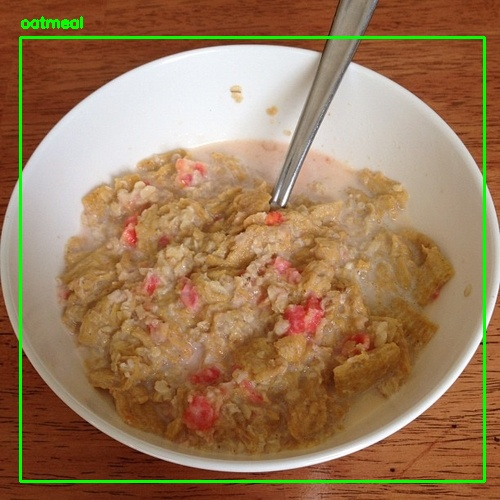

In [24]:
import cv2
import os
from IPython.display import display
from PIL import Image


from collections import defaultdict

category_names = defaultdict(str)
with open("/kaggle/input/uecfood256/UECFOOD256/category.txt", "r") as f:
    lines = f.readlines()[1:]
    for line in lines:
        idx, name = line.strip().split("\t")
        category_names[int(idx)-1] = name  # YOLO indices start from 0


# Define paths
image_dir = "/kaggle/working/dataset/images/train"
label_dir = "/kaggle/working/dataset/labels/train"
output_dir = "/kaggle/working/bbox_visualizations"
os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists



# Get a list of image files
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

# Function to draw bounding boxes
def draw_bounding_boxes(image_path, label_path, output_path):
    img = cv2.imread(image_path)
    h, w, _ = img.shape  # Get image dimensions

    # Read the label file
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, bbox_w, bbox_h = map(float, parts)

                # Convert YOLO format (normalized) to pixel coordinates
                x_center, y_center = int(x_center * w), int(y_center * h)
                bbox_w, bbox_h = int(bbox_w * w), int(bbox_h * h)

                x1 = int(x_center - bbox_w / 2)
                y1 = int(y_center - bbox_h / 2)
                x2 = int(x_center + bbox_w / 2)
                y2 = int(y_center + bbox_h / 2)

                # Draw the bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, category_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    # Save the image instead of showing it
    cv2.imwrite(output_path, img)


# Test on one image
sample_image = image_files[6]
sample_label = os.path.join(label_dir, sample_image.replace(".jpg", ".txt"))
output_image_path = os.path.join(output_dir, "bbox_sample.jpg")

draw_bounding_boxes(os.path.join(image_dir, sample_image), sample_label, output_image_path)

# Display the image in Kaggle Notebook
display(Image.open(output_image_path))


In [25]:
from ultralytics.utils import LOGGER

LOGGER.setLevel(50)  # Set logging level to CRITICAL (only show critical errors)


In [27]:
import torch

In [ ]:
# Load YOLOv8 model (Choose between v8n, v8s, v8m, v8l)
model = YOLO("yolov8n.pt")  # "n" (nano) is the smallest; you can use "yolov8s.pt" for a bigger model

# Train the model
model.train(
    data="/kaggle/working/dataset/data.yaml",  # Path to data.yaml
    epochs=2,  # Number of epochs
    batch=16,  # Adjust batch size based on GPU memory
    imgsz=640,  # Image size for training
    device="cuda" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    workers=2  # Number of CPU threads for data loading
)


100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]
100%|██████████| 5.35M/5.35M [00:00<00:00, 120MB/s]
train: Scanning /kaggle/working/dataset/labels/train... 25116 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25116/25116 [00:22<00:00, 1101.83it/s]
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/dataset/labels/val... 3139 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3139/3139 [00:02<00:00, 1083.90it/s]
        1/2      4.36G      1.988       5.75      2.339         49        640:  24%|██▍       | 383/1570 [02:19<07:52,  2.51it/s]

In [12]:
import shutil

# Define the path where the trained model is saved
trained_model_path = "/kaggle/working/runs/detect/train/weights/best.pt"

# Define the destination path to save it in /kaggle/working/
saved_model_path = "/kaggle/working/yolo_changed_model.pt"

# Copy the model to a safe location
shutil.copy(trained_model_path, saved_model_path)

print(f"✅ Model saved at: {saved_model_path}")


✅ Model saved at: /kaggle/working/best_yolo_model.pt


In [3]:
from ultralytics import YOLO

# Load the trained model
model_path = "/kaggle/input/ep6/pytorch/default/1/best_yolo_model_ep6.pt"
model = YOLO(model_path)

print("✅ Model loaded successfully!")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Model loaded successfully!


In [9]:
import os
import random

# Define the path to training images
image_dir = "/kaggle/working/dataset/images/train"

# Get a list of all images
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Select 3 random images for testing
test_images = random.sample(image_files, 3)

print("Selected test images:", test_images)


Selected test images: ['/kaggle/working/dataset/images/train/99465_136.jpg', '/kaggle/working/dataset/images/train/98643_153.jpg', '/kaggle/working/dataset/images/train/179155_186.jpg']


In [ ]:
metrics = model.val(data="/kaggle/working/dataset/data.yaml", imgsz=640)


Ultralytics 8.3.104 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 8,237,840 parameters, 0 gradients, 46.6 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 16.6MB/s]
val: Scanning /kaggle/working/dataset/labels/val... 3139 images, 0 backgrounds, 179 corrupt: 100%|██████████| 3139/3139 [00:02<00:00, 1209.98it/s]

val: WARNING ⚠️ /kaggle/working/dataset/images/val/101139_149.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0312]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/101997_153.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/10237_107.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0125]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/103969_154.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0187]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/105282_154.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1313]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/10598_107.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0708]
val: WARNING ⚠️ /kaggle/working/dataset/images/val/106609_154.jpg: ignor

val: New cache created: /kaggle/working/dataset/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 174/185 [00:33<00:01,  5.68it/s]


0: 640x640 (no detections), 14.8ms
1: 640x640 (no detections), 14.8ms
2: 640x640 (no detections), 14.8ms
Speed: 2.1ms preprocess, 14.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
📸 Image 1:


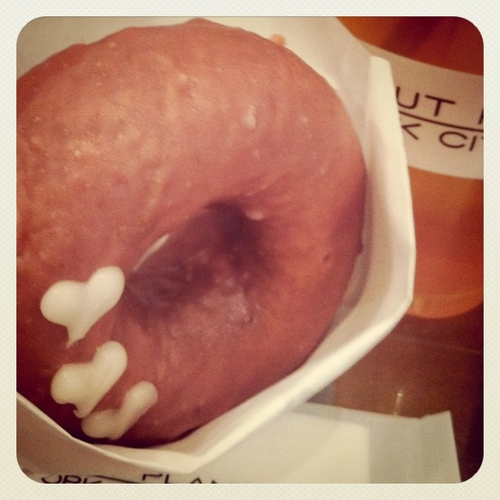

📸 Image 2:


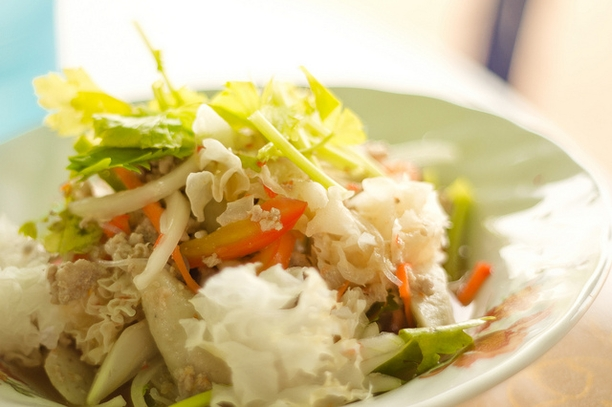

📸 Image 3:


In [ ]:
# Run inference on the selected images
results = model(test_images, save=True, conf=0.25)

# Print detected objects for each image
for i, result in enumerate(results):
    print(f"📸 Image {i+1}:")
    result.show()  # Display the image with bounding boxes


In [16]:
results = model(test_images, save=True, conf=0.1)
